## 1. **Configuração de Ambiente e Reprodução**

In [16]:

# Imports e configurações reproducíveis
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from typing import Optional

# --- Configuração de Reprodução ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# --- Configuração de GPU/Dispositivo ---
# Verifica e configura o TensorFlow para usar a GPU, se disponível
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limita o crescimento da memória da GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Define a estratégia de distribuição para uso de GPU(s)
        strategy = tf.distribute.MirroredStrategy()
        print(f"🔥 Usando estratégia de distribuição com {len(gpus)} GPU(s).")
    except RuntimeError as e:
        # Deve ser chamado antes que os dispositivos lógicos sejam configurados
        print(e)
        strategy = tf.distribute.get_strategy() # Estratégia padrão
else:
    strategy = tf.distribute.get_strategy() # Estratégia padrão (CPU/TPU)
    print("⚠️ Nenhuma GPU detectada. Usando a estratégia padrão.")

# Variáveis para a etapa de treino, onde o modelo é construído e compilado dentro do escopo da estratégia
strategy_scope_used = len(gpus) > 0

# --- Paths e Configurações Globais ---
ROOT = Path("/home/ampliar/cancer-classify-citology/citology-pipeline-Train")
DATA_DIR = ROOT / 'Dataset' / 'pre-processado'
MODELS_DIR = ROOT / 'models'
os.makedirs(MODELS_DIR, exist_ok=True)

TRAIN_CSV = DATA_DIR / 'train_data.csv'
VAL_CSV = DATA_DIR / 'val_data.csv'
TEST_CSV = DATA_DIR / 'test_data.csv'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32 * strategy.num_replicas_in_sync # Ajusta BATCH_SIZE para múltiplas GPUs
EPOCHS_BASELINE = 10
EPOCHS_ROBUST = 20
EPOCHS_FINETUNE = 10
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
IMAGE_ROOT = DATA_DIR # Diretório raiz para as imagens

print('\nConfigurações de Paths:')
print('DATA_DIR =', DATA_DIR)
print('MODELS_DIR =', MODELS_DIR)
print('BATCH_SIZE ESTRATÉGICO =', BATCH_SIZE)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
🔥 Usando estratégia de distribuição com 1 GPU(s).

Configurações de Paths:
DATA_DIR = /home/ampliar/cancer-classify-citology/citology-pipeline-Train/Dataset/pre-processado
MODELS_DIR = /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models
BATCH_SIZE ESTRATÉGICO = 32


## 2. **Carregamento de Dados e Geradores**

Assegura o carregamento dos DataFrames e a criação dos geradores de dados para alimentar o modelo. A separação dos geradores com e sem augmentation permite uma comparação justa entre as etapas.

In [ ]:
# Carregar CSVs e verificar
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

print('\nDistribuição de Dados:')
print(f'Treino: {len(train_df)} | Validação: {len(val_df)} | Teste: {len(test_df)}')
num_classes = train_df['lesion_type'].nunique()
print(f'Número de Classes: {num_classes}')

# --- Funções Utilitárias: Geradores e Construtor de Modelo ---
def make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=False, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Cria ImageDataGenerators e retorna (train_gen, val_gen, test_gen)."""
    if augment:
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
    else:
        # Apenas rescale para geradores de validação/teste e baseline
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Note: 'image_path' e 'lesion_type' dependem do seu CSV
    common_kwargs = dict(x_col='image_path', y_col='lesion_type', target_size=img_size, class_mode='categorical')

    train_gen = train_datagen.flow_from_dataframe(dataframe=train_df, directory=str(image_root) if image_root is not None else None, batch_size=batch_size, shuffle=True, **common_kwargs)
    val_gen = val_datagen.flow_from_dataframe(dataframe=val_df, directory=str(image_root) if image_root is not None else None, batch_size=batch_size, shuffle=False, **common_kwargs)
    # Batch size = 1 para teste facilita a previsão exata se o len(test_df) não for múltiplo de BATCH_SIZE
    test_gen = test_datagen.flow_from_dataframe(dataframe=test_df, directory=str(image_root) if image_root is not None else None, batch_size=1, shuffle=False, **common_kwargs)

    return train_gen, val_gen, test_gen

def build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=1e-4):
    """Constrói um MobileNetV2 com topo customizado e retorna (model, base_model)"""
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model, base

## 3. **Etapa 1: Treinamento Baseline (Base Congelada)**

O treinamento Baseline estabelece a performance inicial do modelo, treinando apenas o top (cabeça) da rede, enquanto as camadas de MobileNetV2 (pesos da ImageNet) permanecem congeladas.

### 3.1. **Treinamento**

In [18]:
# --- Geradores sem augmentation (Baseline) ---
train_gen, val_gen, test_gen_baseline = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=False, batch_size=BATCH_SIZE)
print('\nClasses detectadas:', train_gen.class_indices)

checkpoint_baseline = str(MODELS_DIR / 'baseline_checkpoint.keras')

import tensorflow as tf
# Then use a specific strategy like:
Strategy = tf.distribute.MirroredStrategy()

def train_and_save(model, train_gen, val_gen, epochs, checkpoint_path, early_stop_patience=6, strategy: Optional[Strategy] = None):
    """
    Treina `model` e salva melhor checkpoint em `checkpoint_path` (.keras). 
    Se `strategy` for fornecida, garante que o treinamento (`model.fit`) 
    ocorra dentro do escopo da estratégia. Retorna (history, final_path).
    """
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    callbacks = [
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
    
    # 🌟 O AJUSTE CHAVE: Envolver model.fit() com strategy.scope() se a estratégia existir
    if strategy:
        with strategy.scope():
            history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks, verbose=1)
    else:
        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks, verbose=1)
    
    # --- Salvamento Final ---
    final_path = os.path.join(str(MODELS_DIR), os.path.basename(checkpoint_path).replace('.keras', '_final.keras'))
    
    # É uma boa prática salvar o modelo final *fora* do escopo da estratégia,
    # embora o Keras moderno geralmente lide com isso
    try:
        # Tenta carregar o melhor peso salvo pelo ModelCheckpoint
        best = load_model(checkpoint_path) 
        best.save(final_path)
    except Exception as e:
        print('Aviso: não foi possível recarregar checkpoint para salvar final:', e)
        # Se falhar, salva o modelo atual no final do treinamento (que pode não ser o melhor)
        model.save(final_path) 

    return history, final_path


Found 24949 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.

Classes detectadas: {'HISIL': 0, 'LISIL': 1, 'Normal': 2}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


/home/ampliar/miniconda3/envs/train-pipeline-gpu/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


TypeError: typing.Optional requires a single type. Got <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7df0c14bf9a0>.

In [ ]:
# Construir e Treinar Modelo dentro do strategy scope (se houver GPU)
if strategy_scope_used:
    with strategy.scope():
        baseline_model, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=1e-4)
else:
    baseline_model, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=1e-4)

baseline_model.summary()

print('\n--- Treinamento Baseline (Apenas Topo) ---')
history_baseline, baseline_final_path = train_and_save(baseline_model, train_gen, val_gen, epochs=EPOCHS_BASELINE, checkpoint_path=checkpoint_baseline)
print('Baseline final salvo em:', baseline_final_path)

### 3.2. **Análise de Métricas (Baseline)**

**Função de Perda e Acurácia**\
A função de perda (loss) mede o quão distante as previsões do modelo estão dos rótulos verdadeiros. A queda em val_loss (e o aumento em val_accuracy) sem uma grande divergência em relação às métricas de treino (loss e accuracy) indica um bom aprendizado inicial, sem overfitting.

In [ ]:
def plot_history(history, title=''):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss (Treino)')
    plt.plot(history.history['val_loss'], label='Loss (Validação)')
    plt.title(title + ' - Função de Perda (Categorical Cross-Entropy)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acurácia (Treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (Validação)')
    plt.title(title + ' - Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_baseline, 'Baseline (Apenas Topo)')

**Matriz de Confusão**\
A matriz de confusão (Confusion Matrix) é crucial para o baseline pois revela a performance por classe. Espera-se que, no início, o modelo tenha alta confusão entre classes, especialmente se elas forem visualmente semelhantes, resultando em valores altos fora da diagonal principal.

Found 24949 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.


/home/ampliar/miniconda3/envs/train-pipeline-gpu/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/home/ampliar/miniconda3/envs/train-pipeline-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-11-24 21:45:56.824841: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90201
W0000 00:00:1764031557.028846 1128149 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1764031557.056658 1128149 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy wil

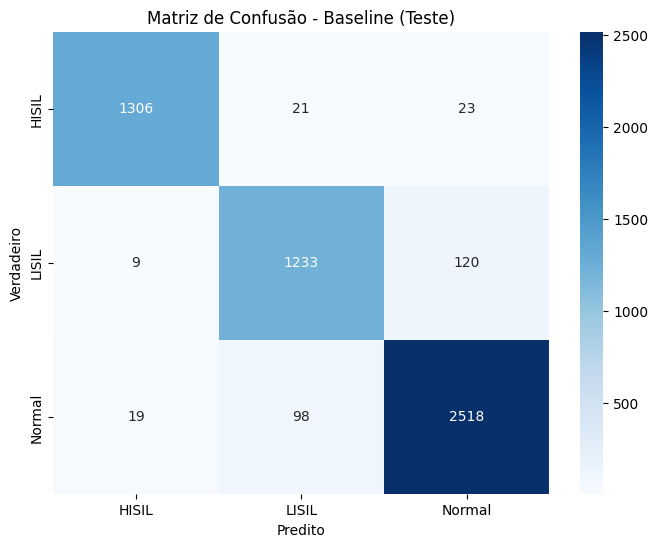


Relatório de Classificação - Baseline (Teste):
              precision    recall  f1-score   support

       HISIL       0.98      0.97      0.97      1350
       LISIL       0.91      0.91      0.91      1362
      Normal       0.95      0.96      0.95      2635

    accuracy                           0.95      5347
   macro avg       0.95      0.94      0.94      5347
weighted avg       0.95      0.95      0.95      5347



In [5]:
# Carregar o melhor modelo baseline para avaliação
# carregar o melhor modelo salvo
path = MODELS_DIR / 'baseline_checkpoint.keras'
if not path.exists():
    path = baseline_final_path  # Usa o final se o checkpoint não existir


model_baseline_eval = load_model(path)

# Gerador de teste (batch_size=1)
_, _, test_gen_eval = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=False, batch_size=BATCH_SIZE)
test_gen_eval.reset()

y_pred_probs = model_baseline_eval.predict(test_gen_eval, steps=len(test_gen_eval), verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen_eval.classes
labels = list(test_gen_eval.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Baseline (Teste)')
plt.show()

print('\nRelatório de Classificação - Baseline (Teste):')
print(classification_report(y_true, y_pred, target_names=labels))

## 4. **Etapa 2: Treinamento Robusto (com Augmentation e Otimização de LR)**

Esta etapa aplica Data Augmentation para melhorar a capacidade de generalização do modelo e mitigar o overfitting. Realiza-se também uma otimização simples de taxa de aprendizado (learning_rate) para encontrar um hiperparâmetro melhor.

### 4.1. **Treinamento e Otimização**

In [ ]:
# Hiperparâmetros candidatos
candidate_lrs = [1e-3, 1e-4, 5e-5]
best_val_acc = -1.0
best_model_path = None
robust_best_path = str(MODELS_DIR / 'robust_best.keras')

# Geradores com augmentation
train_gen_aug, val_gen_aug, _ = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=True, batch_size=BATCH_SIZE)

print('\n--- Treinamento Robusto (Busca por LR) ---')
for lr in candidate_lrs:
    print(f'\n--- Treinando candidato lr={lr} ---')
    checkpoint_path = str(MODELS_DIR / f'robust_checkpoint_lr{str(lr).replace('.', 'p')}.keras')

    # Reconstruir/compilar modelo dentro do strategy scope
    if strategy_scope_used:
        with strategy.scope():
            model_candidate, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=lr)
    else:
        model_candidate, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=lr)


    history, final_path = train_and_save(model_candidate, train_gen_aug, val_gen_aug, epochs=EPOCHS_ROBUST, checkpoint_path=checkpoint_path, early_stop_patience=8)

    # Avalia o melhor checkpoint (monitorado por val_loss)
    try:
        loaded = load_model(checkpoint_path)
        # Necessário usar o gerador de validação com augmentation para a avaliação
        val_gen_aug.reset()
        res = loaded.evaluate(val_gen_aug, verbose=0)
        val_acc = res[1] if len(res) > 1 else None
    except Exception as e:
        print('Falha ao carregar ou avaliar checkpoint:', e)
        # Fallback para o melhor da história
        val_acc = max(history.history.get('val_accuracy', [-1]))

    print(f'lr={lr} -> val_acc={val_acc}')
    if val_acc is not None and val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = checkpoint_path

print('\nMelhor modelo da etapa 2 salvo em:', best_model_path, f'com val_acc={best_val_acc:.4f}')

# Salvar cópia nomeada do melhor modelo
if best_model_path is not None and os.path.exists(best_model_path):
    robust_best = load_model(best_model_path)
    robust_best.save(robust_best_path)
    print('Robust best salvo em:', robust_best_path)
else:
    print('Nenhum modelo válido encontrado na etapa 2. Revertendo para o baseline.')
    robust_best_path = checkpoint_baseline # Usa o baseline como fallback

# Plot do histórico do melhor modelo robusto (necessário carregar o histórico correspondente, ou usar um plot genérico)
# Neste caso, vamos carregar o histórico do melhor modelo salvo (se o nome seguir um padrão)
# Como o history não está salvo, usaremos o último history se o melhor_model_path for o último lr testado.
# Se o melhor modelo não foi o último, este plot pode ser enganoso.
# Para um relatório completo, o histórico deveria ser persistido.
# Para este exemplo, apenas plote o último history (lr=5e-5) para ilustração:
if 'history' in locals():
    plot_history(history, 'Robusto (Último LR Testado)')

### 4.2. **Análise de Métricas (Robusto)**

O Data Augmentation deve ter como impacto a redução da diferença entre a accuracy de treino e de validação, indicando melhor generalização.

**Matriz de Confusão**\
A matriz de confusão do melhor modelo robusto deve apresentar uma melhora significativa em relação ao baseline, com mais previsões corretas (valores maiores na diagonal principal) e menos erros de classificação.

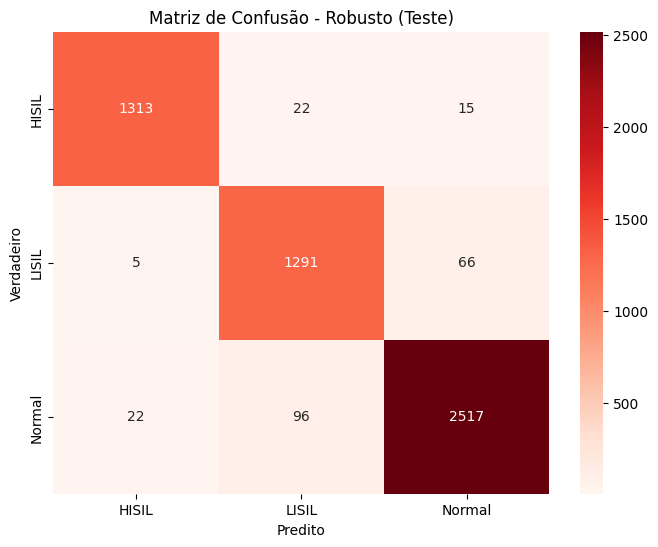


Relatório de Classificação - Robusto (Teste):
              precision    recall  f1-score   support

       HISIL       0.98      0.97      0.98      1350
       LISIL       0.92      0.95      0.93      1362
      Normal       0.97      0.96      0.96      2635

    accuracy                           0.96      5347
   macro avg       0.95      0.96      0.96      5347
weighted avg       0.96      0.96      0.96      5347



In [7]:
# Carregar o melhor modelo robusto para avaliação
robust_best_path = "/home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr0p001_final.keras"
model_robust_eval = load_model(robust_best_path)
test_gen_eval.reset()

y_pred_probs = model_robust_eval.predict(test_gen_eval, steps=len(test_gen_eval), verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Robusto (Teste)')
plt.show()

print('\nRelatório de Classificação - Robusto (Teste):')
print(classification_report(y_true, y_pred, target_names=labels))

## 5. **Etapa 3: Fine-Tuning (Ajuste Fino)**

O Fine-Tuning descongela as camadas superiores da rede base (mais próximas do topo) e as treina com uma taxa de aprendizado muito baixa. Isso permite que o modelo ajuste os features de alto nível aprendidos na ImageNet para o domínio específico das imagens de citologia.

### 5.1. **Treinamento**

In [13]:
# Carregar o melhor modelo da Etapa 2 (ou fallback)
if os.path.exists(robust_best_path):
    model_ft = load_model(robust_best_path)
    print('\nCarregado robust_best.keras para fine-tuning')
else:
    raise FileNotFoundError('Nenhum modelo robusto ou baseline encontrado para fine-tuning.')

# --- Estratégia de Fine-Tuning ---
UNFREEZE_LAST_N = 30 # Número de camadas a descongelar
total_layers = len(model_ft.layers)
# Encontra a camada MobileNetV2 dentro do modelo, se o modelo não for o próprio MobileNetV2
base_model_layer = model_ft.get_layer(index=0) if isinstance(model_ft.layers[0], Model) else model_ft
total_base_layers = len(base_model_layer.layers)
start_idx = max(0, total_base_layers - UNFREEZE_LAST_N)

# Descongela as últimas N camadas da MobileNetV2
for i, layer in enumerate(base_model_layer.layers):
    if i >= start_idx:
        layer.trainable = True
    else:
        layer.trainable = False

print(f'Tornadas treináveis as {total_base_layers - start_idx} últimas camadas da MobileNetV2.')

# Re-compilar com LR reduzida dentro do strategy scope
FT_LR = 1e-5
if strategy_scope_used:
    with strategy.scope():
        # A recompilação deve ser feita no escopo para otimizar o novo otimizador
        model_ft.compile(optimizer=Adam(learning_rate=FT_LR), loss='categorical_crossentropy', metrics=['accuracy'])
else:
    model_ft.compile(optimizer=Adam(learning_rate=FT_LR), loss='categorical_crossentropy', metrics=['accuracy'])


# Preparar geradores (mantemos augmentation)
train_gen_ft, val_gen_ft, _ = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=True, batch_size=BATCH_SIZE)

checkpoint_ft = str(MODELS_DIR / 'final_finetuned_checkpoint.keras')
print('\n--- Treinamento Fine-Tuning ---')
history_ft, final_ft_path = train_and_save(model_ft, train_gen_ft, val_gen_ft, epochs=EPOCHS_FINETUNE, checkpoint_path=checkpoint_ft, early_stop_patience=5)
print('Fine-tuning final salvo em:', final_ft_path)


Carregado robust_best.keras para fine-tuning
Tornadas treináveis as 30 últimas camadas da MobileNetV2.
Found 24949 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.

--- Treinamento Fine-Tuning ---


/home/ampliar/miniconda3/envs/train-pipeline-gpu/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/home/ampliar/miniconda3/envs/train-pipeline-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


RuntimeError: Need to be inside "with strategy.scope()" for <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7df1525bb790>

### 5.2. **Análise de Métricas (Fine-Tuning)**

**Função de Perda e Acurácia**\
O loss e a accuracy devem apresentar uma melhora marginal e mais lenta (devido ao baixo learning_rate) em relação à Etapa 2. Se a loss de validação começar a aumentar rapidamente, indica sobreajuste (overfitting), e o Early Stopping deve intervir.

In [ ]:
plot_history(history_ft, 'Fine-Tuning')

## 6. **Avaliação Final e Relatório**

O relatório final é gerado no conjunto de teste (dados inéditos). O modelo usado é o melhor modelo salvo em qualquer etapa, preferencialmente o Fine-Tuned.

### 6.1. **Avaliação no Conjunto de Teste**

In [ ]:
# Selecionar modelo final para avaliação
candidates = [str(MODELS_DIR / 'final_finetuned_checkpoint.keras'), str(MODELS_DIR / 'robust_best.keras'), str(MODELS_DIR / 'baseline_checkpoint.keras')]
model_eval = None
best_path_eval = None
for p in candidates:
    if os.path.exists(p):
        best_path_eval = p
        model_eval = load_model(p)
        print(f'\nUsando modelo para avaliação final: {os.path.basename(p)}')
        break

if model_eval is None:
    raise FileNotFoundError('Nenhum modelo disponível para avaliação. Execute as etapas anteriores.')

# Criar gerador de teste (batch_size=1 para previsões exatas)
_, _, test_gen_eval = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=False, batch_size=BATCH_SIZE)
test_gen_eval.reset()

print('\nAvaliando no conjunto de teste...')
test_loss, test_acc = model_eval.evaluate(test_gen_eval, steps=len(test_gen_eval), verbose=1)
print(f'\n✅ Performance Final - Teste Loss: {test_loss:.4f} | Teste Acurácia: {test_acc:.4f}')

# Previsões completas para relatório e matriz de confusão
test_gen_eval.reset()
y_pred_probs = model_eval.predict(test_gen_eval, steps=len(test_gen_eval), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen_eval.classes
labels = list(test_gen_eval.class_indices.keys())

### 6.2. **Matriz de Confusão Final e Relatório de Classificação**

**Matriz de Confusão**\
A matriz final deve ser a mais clara possível, com a maioria dos valores concentrados na diagonal principal, indicando que o modelo acertou a classificação na maioria dos casos. Os valores fora da diagonal principal representam os erros.

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title(f'Matriz de Confusão Final (Teste) - {os.path.basename(best_path_eval)}')
plt.show()

Relatório de Classificação

* **Precisão:** De todas as vezes que o modelo previu a Classe X, quantas vezes ele acertou.

* **Recall:** De todas as imagens que são da Classe X, quantas o modelo conseguiu identificar corretamente.

* **F1-Score:** Média harmônica entre Precisão e Recall (uma métrica de balanço).

In [ ]:
print('\n--- Relatório de Classificação Final (Teste) ---')
print(classification_report(y_true, y_pred, target_names=labels))

## 7. **Inferência em Produção (predict_single_image)**

Esta função simula um ambiente de produção. Ela carrega o modelo apenas uma vez e, em seguida, aceita um caminho de imagem por vez, pré-processa-a rapidamente e retorna a previsão e as probabilidades.

In [20]:
import cv2
import numpy as np
import os
import time
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from pathlib import Path

In [21]:
# --- Configurações Globais ---
_LOADED_MODEL = None
_CLASS_NAMES = None
_IMG_SIZE = (224, 224) # Tamanho esperado pelo seu modelo MobileNetV2

# Patch dimensions (devem ser ajustadas para o tamanho de input do modelo, 224x224)
# Usaremos seu PATCH_WIDTH/HEIGHT originais (1024/768) para o corte,
# mas o modelo espera 224x224. Se seu modelo espera 224x224, o patch de 1024x768 deve ser redimensionado.
# **Vamos assumir que o PATCH_WIDTH e PATCH_HEIGHT no seu código de treino eram 224x224.**
PATCH_WIDTH = 1024 
PATCH_HEIGHT = 768 
STRIDE_X = 340
STRIDE_Y = 256
CONTENT_THRESHOLD = 10.0


In [ ]:
# ----------------------------------------------------------------------
# FUNÇÕES DE CARREGAMENTO DO MODELO (MANTIDAS)
# ----------------------------------------------------------------------

def load_inference_model(model_path: str, class_names: list, img_size: tuple = (224, 224)):
    """Carrega o modelo globalmente uma única vez."""
    global _LOADED_MODEL, _CLASS_NAMES, _IMG_SIZE
    if _LOADED_MODEL is None:
        print(f"--- Carregando modelo para inferência de: {model_path} ---")
        try:
            # Garante que o modelo é carregado no formato correto (.keras)
            _LOADED_MODEL = load_model(model_path, compile=False) 
            _CLASS_NAMES = class_names
            _IMG_SIZE = img_size
            print(f"✅ Modelo carregado. Input Size: {_IMG_SIZE}")
        except Exception as e:
            print(f"ERRO ao carregar o modelo: {e}")
            raise

def preprocess_patch(patch_img: np.ndarray) -> np.ndarray:
    """Pré-processa um patch BGR (OpenCV) para o formato esperado pelo Keras/TF."""
    # 1. Converte BGR para RGB (necessário para modelos ImageNet)
    rgb_patch = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
    
    # 2. Rescale e adiciona dimensão de batch (1, H, W, 3)
    img_array = np.expand_dims(rgb_patch, axis=0).astype('float32')
    
    # 3. Normalização (Rescale 0-1)
    img_array /= 255.0
    
    return img_array

# ----------------------------------------------------------------------
# FUNÇÃO PRINCIPAL DE INFERÊNCIA BASEADA EM TILING
# ----------------------------------------------------------------------

def process_and_infer(
    image_path: str,
    output_dir_base: str,
    save_tiles: bool = True
) -> dict:
    """
    Processa uma imagem grande (WSI), gera tiles, realiza a inferência em cada tile
    e agrega os resultados por média. Mede o tempo de processamento e inferência.

    Args:
        image_path (str): Caminho para a imagem grande original.
        output_dir_base (str): Caminho para salvar os tiles gerados. Ex: '/home/user/inferencia'.
        save_tiles (bool): Se True, salva os tiles "bons" na pasta de inferência.

    Returns:
        dict: Resultado final (classe prevista e probabilidades médias) e tempos de execução.
    """
    global _LOADED_MODEL, _CLASS_NAMES, _IMG_SIZE
    
    if _LOADED_MODEL is None:
        raise ValueError("Modelo não carregado. Chame load_inference_model() primeiro.")
    
    start_time = time.time()
    inference_times = []
    
    # --- 1. CONFIGURAÇÃO DE CAMINHOS E DIRETÓRIOS ---
    
    image_filename = os.path.basename(image_path)
    base_filename = os.path.splitext(image_filename)[0]
    
    # Cria a pasta para salvar os tiles específicos desta imagem
    output_dir = os.path.join(output_dir_base, f"tiles_{base_filename}")
    if save_tiles:
        os.makedirs(output_dir, exist_ok=True)
    
    # --- 2. CARREGAMENTO E INICIALIZAÇÃO ---
    
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Erro: Não foi possível ler a imagem em {image_path}")

    # Garante que o patch a ser cortado é do tamanho do input do modelo
    H, W = _IMG_SIZE[0], _IMG_SIZE[1] 
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width, _ = img.shape
    
    total_patches = 0
    good_patches = 0
    
    # Lista para armazenar as probabilidades de todos os patches
    all_probabilities = []
    
    pre_process_time = time.time() - start_time
    
    print(f"--- Iniciando Processamento ({width}x{height}) ---")

    # --- 3. LOGIC OF TILING AND INFERENCE ---

    # Itera sobre altura (Y-axis)
    for y in range(0, height - H + 1, STRIDE_Y):
        # Itera sobre largura (X-axis)
        for x in range(0, width - W + 1, STRIDE_X):
            total_patches += 1
            
            # 3.1. Extract the Patch (Patch size = Model Input size)
            patch_gray = gray[y:y + H, x:x + W]
            patch_color = img[y:y + H, x:x + W]
            
            # 3.2. Filter by Content (Ignorar fundos vazios/brancos)
            std_dev = np.std(patch_gray)
            
            if std_dev > CONTENT_THRESHOLD:
                good_patches += 1
                
                # A. Pré-processamento do Patch para o Modelo
                input_tensor = preprocess_patch(patch_color)
                
                # B. Inferência e Medição de Tempo
                inf_start = time.time()
                predictions = _LOADED_MODEL.predict(input_tensor, verbose=0)
                inf_end = time.time()
                inference_times.append(inf_end - inf_start)
                
                # Salva as probabilidades
                all_probabilities.append(predictions[0])
                
                # C. Salvar Tile (Opcional, para debug)
                if save_tiles:
                    file_name = f"{base_filename}_patch_y{y}_x{x}.png"
                    save_path = os.path.join(output_dir, file_name)
                    cv2.imwrite(save_path, patch_color)

    # --- 4. CÁLCULO DE MÉTRICAS E AGREGAÇÃO ---
    
    total_time = time.time() - start_time
    
    if not all_probabilities:
        return {
            "error": "Nenhum patch com conteúdo suficiente encontrado para inferência.",
            "total_time": total_time
        }

    # Calcula a média das probabilidades de todos os patches "bons"
    mean_probabilities = np.mean(all_probabilities, axis=0)
    
    predicted_index = np.argmax(mean_probabilities)
    predicted_class = _CLASS_NAMES[predicted_index]
    confidence_score = float(mean_probabilities[predicted_index])
    
    all_probs_dict = {name: float(prob) for name, prob in zip(_CLASS_NAMES, mean_probabilities)}

    # --- 5. RESULTADO FINAL E TEMPOS ---

    return {
        "image_filename": image_filename,
        "total_patches_extracted": total_patches,
        "good_patches_inferred": good_patches,
        "final_prediction": predicted_class,
        "confidence_score": confidence_score,
        "mean_probabilities": all_probs_dict,
        "time_breakdown": {
            "pre_process_time_s": pre_process_time,
            "total_inference_time_s": sum(inference_times),
            "avg_inference_per_patch_ms": (sum(inference_times) / good_patches) * 1000 if good_patches > 0 else 0,
            "total_runtime_s": total_time
        }
    }

# ----------------------------------------------------------------------
# EXEMPLO DE USO
# ----------------------------------------------------------------------

# --- DEFINIÇÕES DE CAMINHOS (AJUSTE PARA SEU UBUNTU) ---
ROOT_PROJECT = Path("/home/ampliar/cancer-classify-citology/citology-pipeline-Train") # Ajuste se houver alteração
MODEL_DIR = ROOT_PROJECT / 'models'
OUTPUT_INFERENCE_DIR = ROOT_PROJECT / 'inferencias' # Pasta de saída para os tiles
IMAGE_INPUT_PATH = ROOT_PROJECT / 'Dataset' / '3 Classes' / 'Tile' / 'HISIL' / 'exemplo_img_grande.tif' # Substitua pelo caminho de uma imagem grande real

# --- PARÂMETROS DO MODELO ---
MODEL_PATH = MODEL_DIR / 'final_finetuned_checkpoint.keras' # Seu modelo final
CLASS_NAMES = ['Normal', 'ASCUS', 'LSIL', 'HSIL'] # Ajuste para suas classes exatas

# Garante que a pasta de saída existe
os.makedirs(OUTPUT_INFERENCE_DIR, exist_ok=True)

try:
    # 1. CARREGAR O MODELO (Apenas uma vez)
    load_inference_model(
        model_path=str(MODEL_PATH),
        class_names=CLASS_NAMES,
        img_size=(PATCH_HEIGHT, PATCH_WIDTH)
    )

    # 2. EXECUTAR INFERÊNCIA NA IMAGEM GRANDE
    result = process_and_infer(
        image_path=str(IMAGE_INPUT_PATH),
        output_dir_base=str(OUTPUT_INFERENCE_DIR),
        save_tiles=True
    )

    # 3. MOSTRAR RESULTADOS
    print("\n" + "="*50)
    print("✨ RESULTADO FINAL DA INFERÊNCIA POR TILING ✨")
    print("="*50)
    
    print(f"IMAGEM ANALISADA: {result['image_filename']}")
    print(f"TOTAL DE PATCHES ÚTEIS: {result['good_patches_inferred']} / {result['total_patches_extracted']}")
    print(f"\nCLASSIFICAÇÃO FINAL (Média): **{result['final_prediction']}**")
    print(f"CONFIANÇA (Média): {result['confidence_score']:.4f}")
    
    print("\n--- DETALHES DE PROBABILIDADES MÉDIAS ---")
    for cls, prob in result['mean_probabilities'].items():
        print(f"  {cls}: {prob:.4f}")

    print("\n--- DESEMPENHO (TEMPO) ---")
    print(f"1. Tempo de Pré-Processamento (Tiling/Filtro): {result['time_breakdown']['pre_process_time_s']:.4f} segundos")
    print(f"2. Tempo Total de Inferência (todos patches): {result['time_breakdown']['total_inference_time_s']:.4f} segundos")
    print(f"3. Tempo Médio por Patch Inferred: {result['time_breakdown']['avg_inference_per_patch_ms']:.2f} milissegundos")
    print(f"4. Tempo Total de Execução: {result['time_breakdown']['total_runtime_s']:.4f} segundos")
    print("="*50)

except FileNotFoundError as e:
    print(f"\n⚠️ ERRO: Certifique-se de que o modelo e a imagem existem nos caminhos definidos.")
    print(e)
except ValueError as e:
    print(f"\n⚠️ ERRO: {e}")
except Exception as e:
    print(f"\n❌ ERRO FATAL: {e}")